# Info
This notebook is used to read, combine and save the results from a series of simulations

- The main inputs are the feb filename and the directory where all simulations where run (they can be stored in sub-directories)
- The main output is a dataframe with the combined dataset from all simulations

- Additional inputs that can be left as default are the 

 -- Data keys (for nodes and elements data txt files)

 -- Log filename (csv file containg the run and parameter information)

 -- Dataframe types (how each datapoint sould be interpreted and saved)
 
 -- Read from raw txt or extract data from pickles


To use our modules from FEBio-Python, this notebook must be run inside a "notebooks" folder that shared the "src" directory of FEBio-Python or we must append the path to the src directory

In [1]:
import sys  
from os import path
import numpy as np
import pandas as pd

sys.path.append('../src/')

from modules.sys_functions.find_files_in_folder import find_files, find_folders, search_dirs
from modules.classes import Data_Manipulator

# Set paths and load files

Here we are going to set the main inputs to run this notebook.

-- runs_dir: path to directory containg simulations (each simulation should be in a sub-directory named with its run number ->  run-%s  <- )

-- feb_filename: name of the feb_file to look for. It will not work if this file is not with its correct name

In [2]:
# Main Inputs
runs_dir = "D:\\Igor\\Research_USF\\University of South Florida\\Mao, Wenbin - Igor\\Febio-Models\\Active-Models\\PAQ\\Pressure-Volume-1\\forest_reg"
feb_filename = "myo_hex_coarse_6_epi_60_endo_-60.feb"

In [3]:
# "Optional Inputs"
elems_keys = "sx;sy;sz;sxy;sxz;syz"
nodes_keys = "x;y;z;ux;uy;uz"
nodes_filename = "node.txt"
elems_filename = "elem.txt"
log_filename = "run_log.csv"

df_dtypes = {
    'x': 'float32',
    'y': 'float32',
    'z': 'float32',
    'ux': 'float32',
    'uy': 'float32',
    'uz': 'float32',
    'node': 'category',
    'timestep': 'float32',
    'run_ref': 'uint8',
    'param_val': 'float32',
    'sx': 'float32',
    'sy': 'float32',
    'sz': 'float32',
    'sxy': 'float32',
    'sxz': 'float32',
    'syz': 'float32',
    'elem': 'category'
    }

# This bool will check if the program should read raw txt files directly from results or read pre-created pickle files
READ_PLOT_FILES = True

# This bool lets you use this notebook for a single file
SINGLE_FILE = True
PARAM_VAL = 1 # Only used if SINGLE_FILE is true

In [4]:
# Set paths and find files

log_filepath = path.join(runs_dir, log_filename)
run_dirs = find_folders(runs_dir)
runs = []
runs_nums = []
for (dp, dd, dn) in run_dirs:
    if dn != "pickles":
        _files = []
        feb_files = find_files(dp, ("fileFormat", "feb"))
        txt_files = find_files(dp, ("fileFormat", "txt"))
        _files.extend(feb_files)
        _files.extend(txt_files)
        runs.append(_files)
        if not SINGLE_FILE:
            runs_nums.append(int(dn.split("-")[-1]))
        else:
            runs_nums.append(1)

if not SINGLE_FILE:
    log_df = pd.read_csv(log_filepath)

# Create DataManipulators

DataManipulator are useful to extract nodes and elements data and combina all information within a single dataframe. Remember that nodes and elements contains different data, with different lengths, and, becuase of this, they cannot be analyzed directly. Therefore, DataManipulator will compute all nodal data from elements, and, in the end, we will have all information based on nodal coordinates. 

Since we have the same geometry, we can use one DataManipulator as a reference. The dataframe reads the feb file and save as reference a nodes and elements dictionaries, which contains the correlation between nodes and elements in the mesh. If we want to check different feb files, we must have different datamanipulators.

In [5]:
# This functions checks the total memory usage os a dataframe
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return usage_mb

### Read raw data

The next node reads and saves raw nodes and elements files
* to save memory usage, we will be reading data from nodes/elements and saving into a pickle file and reading each file later

In [6]:
pickles_dir = path.join(runs_dir, "pickles")
tpm_pickles_dir = path.join(pickles_dir, "tpm")

feb_file_ref = runs[0][0][0] # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY
new_dm = Data_Manipulator(feb_file_ref) # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY

m_use = 0
f_ctn = 0

# if LOAD_FROM_PICKLES == True:
#     dms = []
    
#     # print(feb_file_ref)
#     pickles_paths = search_dirs(tpm_pickles_dir, ".pickle")
#     for pp in pickles_paths:
#         # new_dm = Data_Manipulator(feb_file_ref)
#         new_dm.set_data(pickle_path=pp)
#         dms.append(new_dm)

if READ_PLOT_FILES:
    if not path.exists(tpm_pickles_dir):
        os.makedirs(tpm_pickles_dir) 

    # dms = []
    for i, run in enumerate(runs):
        feb_file = nodes_file = elems_file = None
        for (fp, ff, fn) in run:
            if ff == feb_filename:
                feb_file = fp
            elif ff == nodes_filename:
                nodes_file = fp
            elif ff == elems_filename:
                elems_file = fp
        if feb_file != None:
            # print(feb_file)
            # new_dm = Data_Manipulator(feb_file)
            run_num = runs_nums[i]
            if not SINGLE_FILE:
                param_val = log_df.loc[log_df["run#"] == run_num]["param"].values[0]
            else:
                param_val = PARAM_VAL
            if nodes_file != None and elems_file != None:
                pickle_filename = "data-run-{v}.pickle".format(v = run_num)
                new_dm.read_plot_file([nodes_file, elems_file], [nodes_keys, elems_keys], ["node", "elem"], "", run_num, param_val, df_dtypes)
                m_use += mem_usage(new_dm.data)
                f_ctn += 1

                new_dm.data.to_pickle(path.join(tpm_pickles_dir, pickle_filename))
            # dms.append(new_dm)


if m_use != 0:
    print("Total memory usage:", m_use)
    print("Average memory usage per df:", m_use / f_ctn)

    

Total memory usage: 619.5456247329712
Average memory usage per df: 619.5456247329712


### Calculate nodal data

Here we will be using datamanipulators dictionaries to compute nodal data based on elements information

In [7]:
def calculate_nodes_data(dm, nodes_column, elems_colums, elem_data_labels, accepted_nodes=None, dtypes={}):
    # add additional labels
    nodes_colums.extend(["node","timestep","run_ref","param_val"])
    elems_colums.extend(["elem","timestep","run_ref","param_val"])

    # drop not numbers
    nodes_df = dm.data[nodes_colums].dropna()
    elems_df = dm.data[elems_colums].dropna()

    # vectorize elems_df
    elem_vec = elems_df.to_dict('records')
    # set elems dict
    elem_data_dict = dict()
    for elem in elem_vec:
        elem_data_dict[(elem["elem"],elem["timestep"],elem["run_ref"])] = elem
    
    # vectorize nodes_df
    nodes_vec = nodes_df.to_dict('records')
    new_nodes_vec = []

    # loop through nodes and add nodal data based on elemen value
    for node in nodes_vec:

        # get node number
        node_num = node["node"]
        if accepted_nodes != None:
            if node_num not in accepted_nodes:
                continue
        # get node refs
        time_step = node["timestep"]
        run_ref = node["run_ref"]

        # get elems that are connected to given node
        elems_c_node = dm.node_dict[int(node_num)]

        # get elem_data
        elem_data = np.zeros((1,len(elem_data_labels)))
        for elem_num in elems_c_node:
            elem_vals = elem_data_dict[(elem_num, time_step, run_ref)]
            elem_data += np.array([elem_vals[v] for v in elem_data_labels])
        elem_data = elem_data / len(elems_c_node)

        # add nodal data
        for i, el_label in enumerate(elem_data_labels):
            node[el_label] = elem_data[0][i]

        new_nodes_vec.append(node)

    new_df = pd.DataFrame.from_records(new_nodes_vec)

    for column_key in dtypes:
        if column_key in new_df.columns:
            new_df.loc[:,column_key] = new_df[column_key].astype(dtypes[column_key])
    return new_df


In [8]:
nodes_colums = [v for v in nodes_keys.split(";")]
elems_colums = [v for v in elems_keys.split(";")]
elem_data_labels = [v for v in elems_keys.split(";")]
pickles_paths = search_dirs(tpm_pickles_dir, ".pickle")

In [9]:
# test
df_ref = pd.read_pickle(pickles_paths[0])

feb_file_ref = runs[0][0][0] # Using same file as ref since geometry is the same <-- MUST CHANGE IF WE USE DIFFERENT GEOMETRY
dm_ref = Data_Manipulator(feb_file_ref)
dm_ref.set_data(pickle_path=pickles_paths[0])
endo_nodes = set(dm_ref.face_dicts[dm_ref.set_order["Endocardio"]].keys())

In [10]:
pickles_dir = path.join(runs_dir, "pickles")
endo_nodes_data_pickles_dir = path.join(pickles_dir, "endo-nodes-data")
if not path.exists(endo_nodes_data_pickles_dir):
    os.makedirs(endo_nodes_data_pickles_dir)

for pp in pickles_paths:
    # here I am getting just the endocardio node data based on ONE reference FEBIO file (same geometry)
    dm_ref.set_data(pickle_path=pp)
    df = calculate_nodes_data(dm_ref,nodes_colums, elems_colums, elem_data_labels, endo_nodes, dtypes=df_dtypes)
    new_file_name = path.join(endo_nodes_data_pickles_dir, "endo-{v}".format(v=path.basename(pp)))
    df.to_pickle(new_file_name)



# Group dfs and calculate volumes

Now we have all the datasets that we are interested in. We can now combine them and extract the volume information

In [11]:
def combine_pickles(pickles_paths, df=None, started=False, _max=2):

    if len(pickles_paths) <= _max:
        # print([path.basename(pp) for pp in pickles_paths])
        if started:
            df_list = [df]
            df_list.extend([pd.read_pickle(pp) for pp in pickles_paths])
        else:
            df_list = [pd.read_pickle(pp) for pp in pickles_paths]

        df = pd.concat(df_list, sort=False).drop_duplicates(
        ).reset_index(drop=True)
        
        # print(df["run_ref"].describe())

        return df
        # return pd.concat(df_list, sort=False).drop_duplicates(
        # ).reset_index(drop=True)
    else:
        p = len(pickles_paths) // 2
        fh = pickles_paths[:p]
        sh = pickles_paths[p:]

        fh_df  = combine_pickles(fh, df, True)
        sh_df = combine_pickles(sh, fh_df, True)

        return sh_df

        # print("fh")

        # df = pd.concat([fh_df, sh_df], sort=False).drop_duplicates(
        # ).reset_index(drop=True)

        

    return sh_df


In [12]:
pickles_dir = path.join(runs_dir, "pickles",)
endo_nodes_data_pickles_dir = path.join(pickles_dir, "endo-nodes-data")
pickles_paths = search_dirs(endo_nodes_data_pickles_dir, ".pickle", files=[])

endo_data = combine_pickles(pickles_paths)


Once the data is combined, lets group them by param_val and timestep. This way, we will be able to iterate over them and calculate the volume by param and timestep

In [13]:
endo_data_grouped = endo_data.groupby(["param_val", "timestep"])

This next function is a wrapper to calculate the volume of a given nodal dataframe. It accepts the dataframe and the position references ['x','y','z']. It returns the volume in units cubic of input data

In [14]:
from scipy.spatial import ConvexHull
def get_volume(df, labels=["x","y","z"]):
    return ConvexHull(df[labels].to_numpy(), qhull_options="Qt Qx Qv Q4 Q14").volume

Since we did not record the pressure data, we can define a function to return a pressure given a timestep. If we change the pressure-time curve, we can just modify this funtion.

In [15]:
# include the equation for the pressure
def get_linear_pressure(t):
    if t < 0.1:
        return 0.0
    else:
        return (16/0.2) * (t - 0.1)

Now, the fun part: calculate the volume!

To do so, we will create a vector (one dimension list) with the computed values and transform into a dataframe afterwards. 

In [16]:
initial_volume = get_volume(dm_ref.initial_pos.loc[dm_ref.initial_pos["node"].isin(endo_nodes)])
print("initial volume:", initial_volume)

vol_vec = list()
for name, group in endo_data_grouped:
    volume = get_volume(group)
    vol_data = {
        "param_val": name[0],
        "timestep": name[1],
        "volume": volume * 0.001,
        "perc_vol": (volume - initial_volume)/(initial_volume),
        "pressure": get_linear_pressure(name[1])
    }
    vol_vec.append(vol_data)
vol_df = pd.DataFrame.from_records(vol_vec)

# Save final dataframe

At last, we have our final dataframe. we will save it as a pickle and excel format.

In [17]:
pickles_dir = path.join(runs_dir, "pickles",)
final_data_dir = path.join(pickles_dir, "final-data")
if not path.exists(final_data_dir):
    os.makedirs(final_data_dir)

f_filename = path.join(final_data_dir, "final-df.pickle")
vol_df.to_pickle(f_filename)
f_filename = path.join(final_data_dir, "final-df.xlsx")
vol_df.to_excel(f_filename)


## Last check the results

To analyze the results, we have to group our dataset based on param_val, which will facilitate its analysis

In [18]:
vol_df_grouped = vol_df.groupby("param_val")

Text(0, 0.5, 'Volume %')

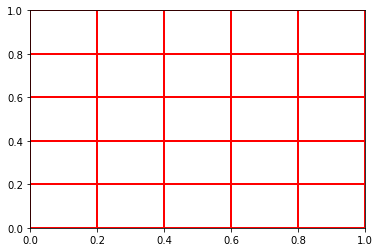

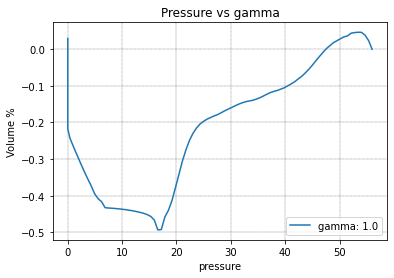

In [19]:
from matplotlib import pyplot as plt
# grid = plt.grid(color='r', linestyle='-', linewidth=2)
fig, ax = plt.subplots(1,1)
legends = []
for (name, group) in vol_df_grouped:
    group.plot(kind='line',x='pressure',y='perc_vol',ax=ax, title="Pressure vs gamma")
    legends.append("gamma: {v}".format(v=np.round(name,3)))
    # group.plot(kind='line',x='pressure',y='perc_vol', ax=ax, secondary_y=True)
    # group.plot(x =['pressure', 'pressure'], y=['volume', 'perc_vol'], title=name, secondary_y=True, grid=grid)
ax.grid(color='k', linestyle='--', linewidth=0.25)
ax.legend(legends)
ax.set_ylabel("Volume %")


Text(0, 0.5, 'Volume [ml]')

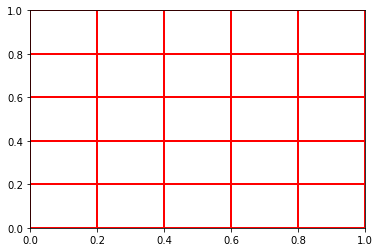

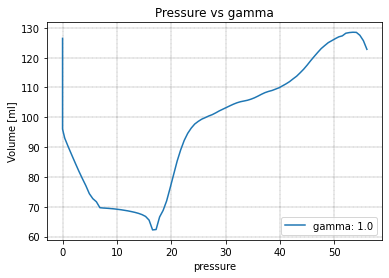

In [20]:
from matplotlib import pyplot as plt
# grid = plt.grid(color='r', linestyle='-', linewidth=2)
fig2, ax2 = plt.subplots(1,1)
legends = []
for (name, group) in vol_df_grouped:
    group.plot(kind='line',x='pressure',y='volume',ax=ax2, title="Pressure vs gamma")
    legends.append("gamma: {v}".format(v=np.round(name,3)))
    # group.plot(kind='line',x='pressure',y='perc_vol', ax=ax, secondary_y=True)
    # group.plot(x =['pressure', 'pressure'], y=['volume', 'perc_vol'], title=name, secondary_y=True, grid=grid)
ax2.grid(color='k', linestyle='--', linewidth=0.25)
ax2.legend(legends)
ax2.set_ylabel("Volume [ml]")

In [21]:
# from matplotlib.backends.backend_pdf import PdfPages

# pp = PdfPages('Pressure-vs-gamma.pdf')
# pp.savefig(fig1)
# pp.savefig(fig2)
# pp.close()

Text(0, 0.5, 'Volume [ml]')

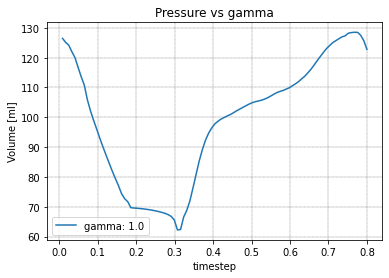

In [22]:
from matplotlib import pyplot as plt
# grid = plt.grid(color='r', linestyle='-', linewidth=2)
fig2, ax2 = plt.subplots(1,1)
legends = []
for (name, group) in vol_df_grouped:
    group.plot(kind='line',x='timestep',y='volume',ax=ax2, title="Pressure vs gamma")
    legends.append("gamma: {v}".format(v=np.round(name,3)))
    # group.plot(kind='line',x='pressure',y='perc_vol', ax=ax, secondary_y=True)
    # group.plot(x =['pressure', 'pressure'], y=['volume', 'perc_vol'], title=name, secondary_y=True, grid=grid)
ax2.grid(color='k', linestyle='--', linewidth=0.25)
ax2.legend(legends)
ax2.set_ylabel("Volume [ml]")